In [1]:
import re
import csv
import matplotlib.pyplot as plt
import joblib

import numpy as np

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
from model import TFIDF, MultinomialNaiveBayes, SVM
from kfold_validation import KFoldValidation

In [3]:
lyrics = []
label = []
title = []
artist = []

with open("dataset/Dataset_V3.csv", mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    for doc in reader:
        lyrics.append(doc["lyrics"])
        label.append(int(doc["emotion"]))
        title.append(doc["song_name"])
        artist.append(doc["artist"])

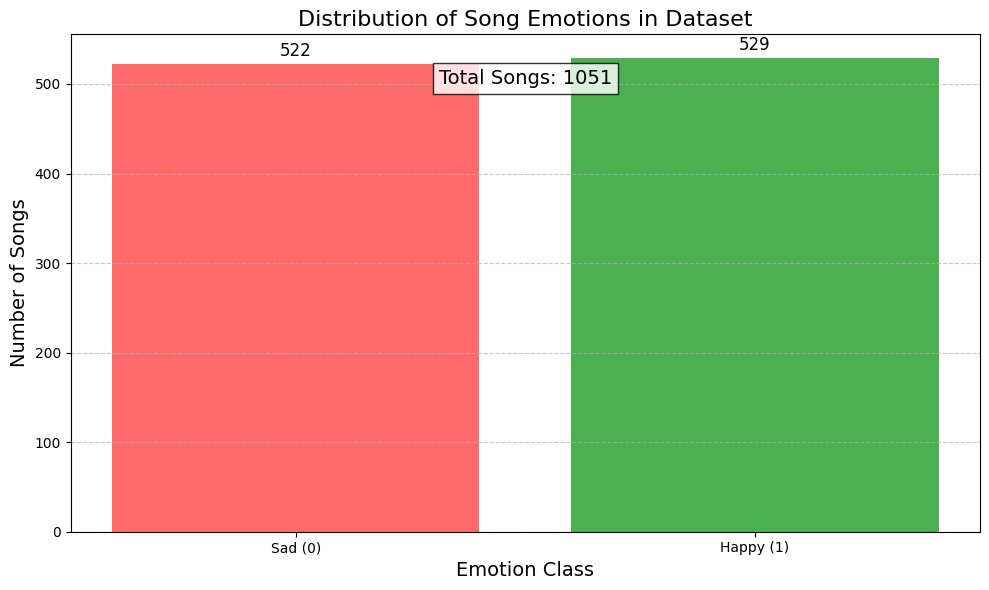

In [4]:
# Show the dataset in Graph
# How Many Lyrics and How Many in Each Class (Sad and Happy)

# Count the number of examples in each class
class_counts = np.bincount(label)

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar chart showing class distribution
bars = ax.bar(['Sad (0)', 'Happy (1)'], class_counts, color=['#FF6B6B', '#4CAF50'])

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height}', ha='center', va='bottom', fontsize=12)

# Add title and labels
ax.set_title('Distribution of Song Emotions in Dataset', fontsize=16)
ax.set_xlabel('Emotion Class', fontsize=14)
ax.set_ylabel('Number of Songs', fontsize=14)

# Add a text box showing total count
total_count = len(label)
plt.text(0.5, 0.9, f'Total Songs: {total_count}', 
         horizontalalignment='center',
         transform=ax.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.8))

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
    




In [5]:
def case_folding(list_doc):
    temp = []
    for doc in list_doc:
        temp.append(doc.lower())
    return temp


def normalization(list_doc):
    temp = []
    for doc in list_doc:
        temp.append(" ".join(re.findall(r"[a-zA-Z]+", doc)))
    return temp


def tokenization(list_doc):
    temp = []
    for doc in list_doc:
        temp.append(doc.split())
    return temp


def stopword_removal(list_of_tokenize_doc):
    result = []
    stopwords = [
        "ada", "adalah", "adanya", "adapun", "agak", "agaknya", "agar", "akan", "akankah", "akhir", "akhiri", "akhirnya", "aku", "akulah", "amat", "amatlah", "anda", "andalah", "antar", "antara", "antaranya", "apa", "apaan", "apabila", "apakah", "apalagi", "apatah", "artinya", "asal", "asalkan", "atas", "atau", "ataukah", "ataupun", "awal", "awalnya", "bagai", "bagaikan", "bagaimana", "bagaimanakah", "bagaimanapun", "bagi", "bagian", "bahkan", "bahwa", "bahwasanya", "baik", "bakal", "bakalan", "balik", "banyak", "bapak", "baru", "bawah", "beberapa", "begini", "beginian", "beginikah", "beginilah", "begitu", "begitukah", "begitulah", "begitupun", "bekerja", "belakang", "belakangan", "belum", "belumlah", "benar", "benarkah", "benarlah", "berada", "berakhir", "berakhirlah", "berakhirnya", "berapa", "berapakah", "berapalah", "berapapun", "berarti", "berawal", "berbagai", "berdatangan", "beri", "berikan", "berikut", "berikutnya", "berjumlah", "berkali-kali", "berkata", "berkehendak", "berkeinginan", "berkenaan", "berlainan", "berlalu", "berlangsung", "berlebihan", "bermacam", "bermacam-macam", "bermaksud", "bermula", "bersama", "bersama-sama", "bersiap", "bersiap-siap", "bertanya", "bertanya-tanya", "berturut", "berturut-turut", "bertutur", "berujar", "berupa", "besar", "betul", "betulkah", "biasa", "biasanya", "bila", "bilakah", "bisa", "bisakah", "boleh", "bolehkah", "bolehlah", "buat", "bukan", "bukankah", "bukanlah", "bukannya", "bulan", "bung", "cara", "caranya", "cukup", "cukupkah", "cukuplah", "cuma", "dahulu", "dalam", "dan", "dapat", "dari", "daripada", "datang", "dekat", "demi", "demikian", "demikianlah", "dengan", "depan", "di", "dia", "diakhiri", "diakhirinya", "dialah", "diantara", "diantaranya", "diberi", "diberikan", "diberikannya", "dibuat", "dibuatnya", "didapat", "didatangkan", "digunakan", "diibaratkan", "diibaratkannya", "diingat", "diingatkan", "diinginkan", "dijawab", "dijelaskan", "dijelaskannya", "dikarenakan", "dikatakan", "dikatakannya", "dikerjakan", "diketahui", "diketahuinya", "dikira", "dilakukan", "dilalui", "dilihat", "dimaksud", "dimaksudkan", "dimaksudkannya", "dimaksudnya", "diminta", "dimintai", "dimisalkan", "dimulai", "dimulailah", "dimulainya", "dimungkinkan", "dini", "dipastikan", "diperbuat", "diperbuatnya", "dipergunakan", "diperkirakan", "diperlihatkan", "diperlukan", "diperlukannya", "dipersoalkan", "dipertanyakan", "dipunyai", "diri", "dirinya", "disampaikan", "disebut", "disebutkan", "disebutkannya", "disini", "disinilah", "ditambahkan", "ditandaskan", "ditanya", "ditanyai", "ditanyakan", "ditegaskan", "ditujukan", "ditunjuk", "ditunjuki", "ditunjukkan", "ditunjukkannya", "ditunjuknya", "dituturkan", "dituturkannya", "diucapkan", "diucapkannya", "diungkapkan", "dong", "dua", "dulu", "empat", "enggak", "enggaknya", "entah", "entahlah", "guna", "gunakan", "hal", "hampir", "hanya", "hanyalah", "hari", "harus", "haruslah", "harusnya", "hendak", "hendaklah", "hendaknya", "hingga", "ia", "ialah", "ibarat", "ibaratkan", "ibaratnya", "ibu", "ikut", "ingat", "ingat-ingat", "ingin", "inginkah", "inginkan", "ini", "inikah", "inilah", "itu", "itukah", "itulah", "jadi", "jadilah", "jadinya", "jangan", "jangankan", "janganlah", "jauh", "jawab", "jawaban", "jawabnya", "jelas", "jelaskan", "jelaslah", "jelasnya", "jika", "jikalau", "juga", "jumlah", "jumlahnya", "justru", "kala", "kalau", "kalaulah", "kalaupun", "kalian", "kami", "kamilah", "kamu", "kamulah", "kan", "kapan", "kapankah", "kapanpun", "karena", "karenanya", "kasus", "kata", "katakan", "katakanlah", "katanya", "ke", "keadaan", "kebetulan", "kecil", "kedua", "keduanya", "keinginan", "kelamaan", "kelihatan", "kelihatannya", "kelima", "keluar", "kembali", "kemudian", "kemungkinan", "kemungkinannya", "kenapa", "kepada", "kepadanya", "kesampaian", "keseluruhan", "keseluruhannya", "keterlaluan", "ketika", "khususnya", "kini", "kinilah", "kira", "kira-kira", "kiranya", "kita", "kitalah", "kok", "kurang", "lagi", "lagian", "lah", "lain", "lainnya", "lalu", "lama", "lamanya", "lanjut", "lanjutnya", "lebih", "lewat", "lima", "luar", "macam", "maka", "makanya", "makin", "malah", "malahan", "mampu", "mampukah", "mana", "manakala", "manalagi", "masa", "masalah", "masalahnya", "masih", "masihkah", "masing", "masing-masing", "mau", "maupun", "melainkan", "melakukan", "melalui", "melihat", "melihatnya", "memang", "memastikan", "memberi", "memberikan", "membuat", "memerlukan", "memihak", "meminta", "memintakan", "memisalkan", "memperbuat", "mempergunakan", "memperkirakan", "memperlihatkan", "mempersiapkan", "mempersoalkan", "mempertanyakan", "mempunyai", "memulai", "memungkinkan", "menaiki", "menambahkan", "menandaskan", "menanti", "menanti-nanti", "menantikan", "menanya", "menanyai", "menanyakan", "mendapat", "mendapatkan", "mendatang", "mendatangi", "mendatangkan", "menegaskan", "mengakhiri", "mengapa", "mengatakan", "mengatakannya", "mengenai", "mengerjakan", "mengetahui", "menggunakan", "menghendaki", "mengibaratkan", "mengibaratkannya", "mengingat", "mengingatkan", "menginginkan", "mengira", "mengiranya", "mengucapkan", "mengucapkannya", "mengungkapkan", "menjadi", "menjawab", "menjelaskan", "menuju", "menunjuk", "menunjuki", "menunjukkan", "menunjuknya", "menurut", "menuturkan", "menyampaikan", "menyangkut", "menyatakan", "menyebutkan", "menyeluruh", "menyiapkan", "merasa", "mereka", "merekalah", "merupakan", "meski", "meskipun", "meyakini", "meyakinkan", "minta", "mirip", "misal", "misalkan", "misalnya", "mula", "mulai", "mulailah", "mulanya", "mungkin", "mungkinkah", "nah", "naik", "namun", "nanti", "nantinya", "nyaris", "nyatanya", "oleh", "olehnya", "pada", "padahal", "padanya", "pak", "paling", "panjang", "pantas", "para", "pasti", "pastilah", "penting", "pentingnya", "per", "percuma", "perlu", "perlukah", "perlunya", "pernah", "persoalan", "pertama", "pertama-tama", "pertanyaan", "pertanyakan", "pihak", "pihaknya", "pukul", "pula", "pun", "punya", "rasa", "rasanya", "rupa", "rupanya", "saat", "saatnya", "saja", "sajalah", "saling", "sama", "sama-sama", "sambil", "sampai", "sampai-sampai", "sampaikan", "sana", "sangat", "sangatlah", "satu", "saya", "sayalah", "se", "sebab", "sebabnya", "sebagai", "sebagaimana", "sebagainya", "sebagian", "sebaik", "sebaik-baiknya", "sebaiknya", "sebaliknya", "sebanyak", "sebegini", "sebegitu", "sebelum", "sebelumnya", "sebenarnya", "seberapa", "sebesar", "sebetulnya", "sebisanya", "sebuah", "sebut", "sebutlah", "sebutnya", "secara", "secukupnya", "sedang", "sedangkan", "sedemikian", "sedikit", "sedikitnya", "seenaknya", "segala", "segalanya", "segera", "seharusnya", "sehingga", "seingat", "sejak", "sejauh", "sejenak", "sejumlah", "sekadar", "sekadarnya", "sekali", "sekali-kali", "sekalian", "sekaligus", "sekalipun", "sekarang", "sekaranglah", "sekecil", "seketika", "sekiranya", "sekitar", "sekitarnya", "sekurang-kurangnya", "sekurangnya", "sela", "selain", "selaku", "selalu", "selama", "selama-lamanya", "selamanya", "selanjutnya", "seluruh", "seluruhnya", "semacam", "semakin", "semampu", "semampunya", "semasa", "semasih", "semata", "semata-mata", "semaunya", "sementara", "semisal", "semisalnya", "sempat", "semua", "semuanya", "semula", "sendiri", "sendirian", "sendirinya", "seolah", "seolah-olah", "seorang", "sepanjang", "sepantasnya", "sepantasnyalah", "seperlunya", "sepertinya", "sepihak", "sering", "seringnya", "serta", "serupa", "sesaat", "sesama", "sesampai", "sesegera", "sesekali", "seseorang", "sesuatu", "sesuatunya", "sesudah", "sesudahnya", "setelah", "setempat", "setengah", "seterusnya", "setiap", "setiba", "setibanya", "setidak-tidaknya", "setidaknya", "setinggi", "seusai", "sewaktu", "siap", "siapa", "siapakah", "siapapun", "sini", "sinilah", "soal", "soalnya", "suatu", "sudah", "sudahkah", "sudahlah", "supaya", "tadi", "tadinya", "tahu", "tahun", "tak", "tambah", "tambahnya", "tampak", "tampaknya", "tandas", "tandasnya", "tanpa", "tanya", "tanyakan", "tanyanya", "tapi", "tegas", "tegasnya", "telah", "tempat", "tengah", "tentang", "tentu", "tentulah", "tentunya", "tepat", "terakhir", "terasa", "terbanyak", "terberi", "terhadap", "terhadapnya", "terjadi", "terjadilah", "terjadinya", "terkira", "terlalu", "terlebih", "terlihat", "termasuk", "ternyata", "tersampaikan", "tersebut", "tersebutlah", "tertentu", "tertutup", "tertuju", "terus", "terutama", "tetap", "tetapi", "tiap", "tiba", "tiba-tiba", "tidak", "tidakkah", "tidaklah", "tinggi", "toh", "tunjuk", "turut", "tutur", "tuturnya", "ucap", "ucapnya", "ujar", "ujarnya", "umum", "umumnya", "ungkap", "ungkapnya", "untuk", "usah", "usai", "waduh", "wah", "wahai", "waktu", "waktunya", "walau", "walaupun", "wong", "yaitu", "yakin", "yakni", "yang"
    ]
    for doc in list_of_tokenize_doc:
        temp = []
        for word in doc:
            if word in stopwords:
                continue
            if len(word) < 2:
                continue
            temp.append(word)
        result.append(temp)
    return result


def stemming(list_of_tokenize_doc):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    result = []
    for doc in list_of_tokenize_doc:
        temp = []
        for word in doc:
            temp.append(stemmer.stem(word))
        result.append(temp)
    return result

In [6]:
case_folding_lyrics = case_folding(lyrics)
normalization_lyrics = normalization(case_folding_lyrics)
tokenization_lyrics = tokenization(normalization_lyrics)
stopword_removal_lyrics = stopword_removal(tokenization_lyrics)

In [7]:
stemming_lyrics = stemming(stopword_removal_lyrics)

In [8]:
TFIDF_vectorizer = TFIDF()
X = TFIDF_vectorizer.fit_transform([' '.join(sentence) for sentence in stemming_lyrics])

In [9]:
mnb = MultinomialNaiveBayes()
svm = SVM(C=1)

# Evaluation 

In [10]:
results = KFoldValidation(mnb, svm, X, np.array(label), n_splits=5)
results

{'naive_bayes': {'metrics': {'accuracy': {'mean': np.float64(0.6593726021214172),
    'std': np.float64(0.034273818423358186),
    'scores': [0.6587677725118484,
     0.6428571428571429,
     0.6904761904761905,
     0.7,
     0.6047619047619047]},
   'precision': {'mean': np.float64(0.6691229895674586),
    'std': np.float64(0.031192058571971482),
    'scores': [0.6646973297169929,
     0.673136645962733,
     0.6905475606538373,
     0.7041647597254005,
     0.6130686517783291]},
   'recall': {'mean': np.float64(0.6593726021214172),
    'std': np.float64(0.034273818423358186),
    'scores': [0.6587677725118484,
     0.6428571428571429,
     0.6904761904761905,
     0.7,
     0.6047619047619047]},
   'f1': {'mean': np.float64(0.6571511249792173),
    'std': np.float64(0.0353537352029546),
    'scores': [0.6579084001094676,
     0.6341861085583849,
     0.6903708505523592,
     0.6993802637851582,
     0.6039100018907166]}},
  'final_model': <model.MultinomialNaiveBayes at 0x1f4405e8b3

# Save The Result


In [11]:
# Save the result into json file
import json

results_dict = {
    "Multinomial Naive Bayes": results["naive_bayes"],
    "SVM": results["svm"]
}

results_dict["Multinomial Naive Bayes"]["final_model"] = str(mnb)
results_dict["SVM"]["final_model"] = str(svm)

with open("output/results.json", "w") as outfile:
    json.dump(results_dict, outfile, indent=4)

# Save the model
joblib.dump(mnb, "output/model_mnb.joblib")
joblib.dump(svm, "output/model_svm.joblib")
joblib.dump(TFIDF_vectorizer, "output/tfidf.joblib")

['output/tfidf.joblib']

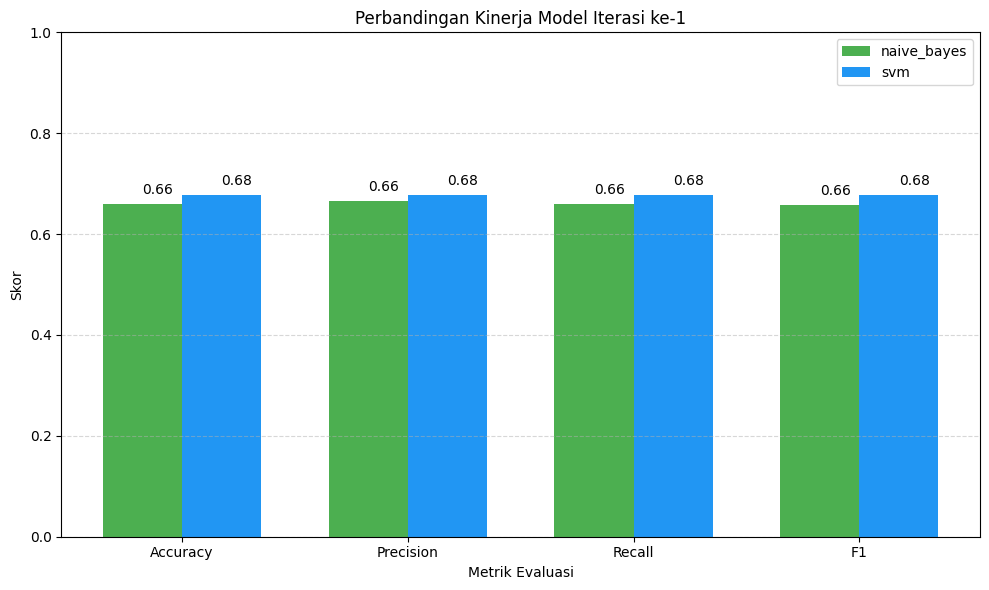

In [12]:
# Persiapan data untuk plotting
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Filter models to only include those with metrics dictionary
models = [key for key in results.keys() if isinstance(results[key], dict) and 'metrics' in results[key]]

score_1 = {model: [results[model]['metrics'][m]['scores'][0] for m in metrics] for model in models}

# Plot
x = np.arange(len(metrics))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - bar_width/2, score_1[models[0]], bar_width, capsize=5,
               label=models[0], color='#4CAF50')
bars2 = ax.bar(x + bar_width/2, score_1[models[1]], bar_width, capsize=5,
               label=models[1], color='#2196F3')

# Label dan dekorasi
ax.set_xlabel('Metrik Evaluasi')
ax.set_ylabel('Skor')
ax.set_title('Perbandingan Kinerja Model Iterasi ke-1')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_ylim(0, 1)
ax.legend()

# Tambahkan nilai di atas bar
for i in range(len(metrics)):
    ax.text(x[i] - bar_width/2, score_1[models[0]][i] + 0.02, f'{score_1[models[0]][i]:.2f}', ha='left')
    ax.text(x[i] + bar_width/2, score_1[models[1]][i] + 0.02, f'{score_1[models[1]][i]:.2f}', ha='left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


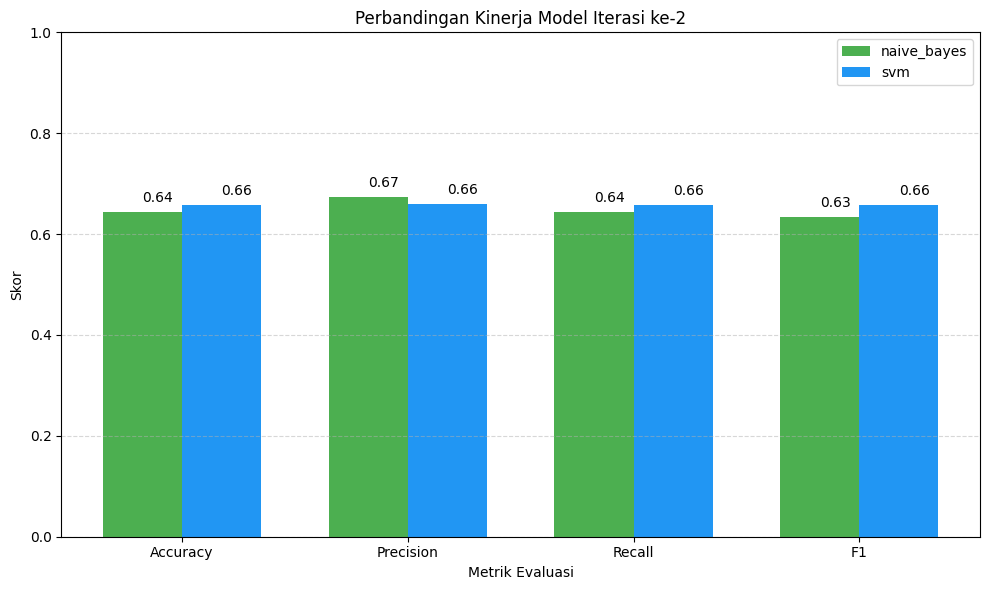

In [13]:
# Persiapan data untuk plotting
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Filter models to only include those with metrics dictionary
models = [key for key in results.keys() if isinstance(results[key], dict) and 'metrics' in results[key]]

score_2 = {model: [results[model]['metrics'][m]['scores'][1] for m in metrics] for model in models}

# Plot
x = np.arange(len(metrics))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - bar_width/2, score_2[models[0]], bar_width, capsize=5,
               label=models[0], color='#4CAF50')
bars2 = ax.bar(x + bar_width/2, score_2[models[1]], bar_width, capsize=5,
               label=models[1], color='#2196F3')

# Label dan dekorasi
ax.set_xlabel('Metrik Evaluasi')
ax.set_ylabel('Skor')
ax.set_title('Perbandingan Kinerja Model Iterasi ke-2')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_ylim(0, 1)
ax.legend()

# Tambahkan nilai di atas bar
for i in range(len(metrics)):
    ax.text(x[i] - bar_width/2, score_2[models[0]][i] + 0.02, f'{score_2[models[0]][i]:.2f}', ha='left')
    ax.text(x[i] + bar_width/2, score_2[models[1]][i] + 0.02, f'{score_2[models[1]][i]:.2f}', ha='left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

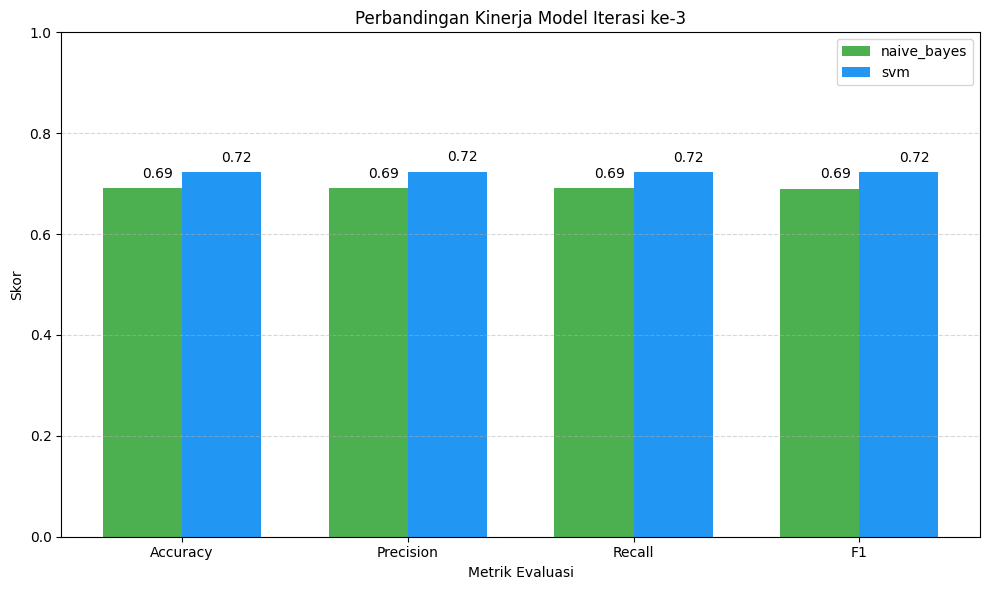

In [14]:
# Persiapan data untuk plotting
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Filter models to only include those with metrics dictionary
models = [key for key in results.keys() if isinstance(results[key], dict) and 'metrics' in results[key]]

score_3 = {model: [results[model]['metrics'][m]['scores'][2] for m in metrics] for model in models}

# Plot
x = np.arange(len(metrics))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - bar_width/2, score_3[models[0]], bar_width, capsize=5,
               label=models[0], color='#4CAF50')
bars2 = ax.bar(x + bar_width/2, score_3[models[1]], bar_width, capsize=5,
               label=models[1], color='#2196F3')

# Label dan dekorasi
ax.set_xlabel('Metrik Evaluasi')
ax.set_ylabel('Skor')
ax.set_title('Perbandingan Kinerja Model Iterasi ke-3')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_ylim(0, 1)
ax.legend()

# Tambahkan nilai di atas bar
for i in range(len(metrics)):
    ax.text(x[i] - bar_width/2, score_3[models[0]][i] + 0.02, f'{score_3[models[0]][i]:.2f}', ha='left')
    ax.text(x[i] + bar_width/2, score_3[models[1]][i] + 0.02, f'{score_3[models[1]][i]:.2f}', ha='left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

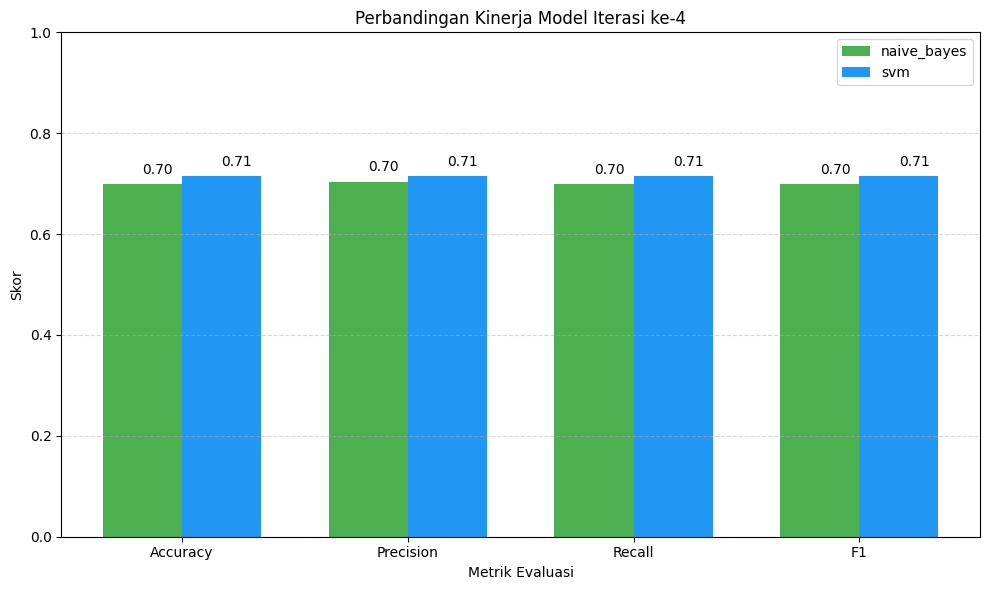

In [15]:
# Persiapan data untuk plotting
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Filter models to only include those with metrics dictionary
models = [key for key in results.keys() if isinstance(results[key], dict) and 'metrics' in results[key]]

score_4 = {model: [results[model]['metrics'][m]['scores'][3] for m in metrics] for model in models}

# Plot
x = np.arange(len(metrics))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - bar_width/2, score_4[models[0]], bar_width, capsize=5,
               label=models[0], color='#4CAF50')
bars2 = ax.bar(x + bar_width/2, score_4[models[1]], bar_width, capsize=5,
               label=models[1], color='#2196F3')

# Label dan dekorasi
ax.set_xlabel('Metrik Evaluasi')
ax.set_ylabel('Skor')
ax.set_title('Perbandingan Kinerja Model Iterasi ke-4')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_ylim(0, 1)
ax.legend()

# Tambahkan nilai di atas bar
for i in range(len(metrics)):
    ax.text(x[i] - bar_width/2, score_4[models[0]][i] + 0.02, f'{score_4[models[0]][i]:.2f}', ha='left')
    ax.text(x[i] + bar_width/2, score_4[models[1]][i] + 0.02, f'{score_4[models[1]][i]:.2f}', ha='left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

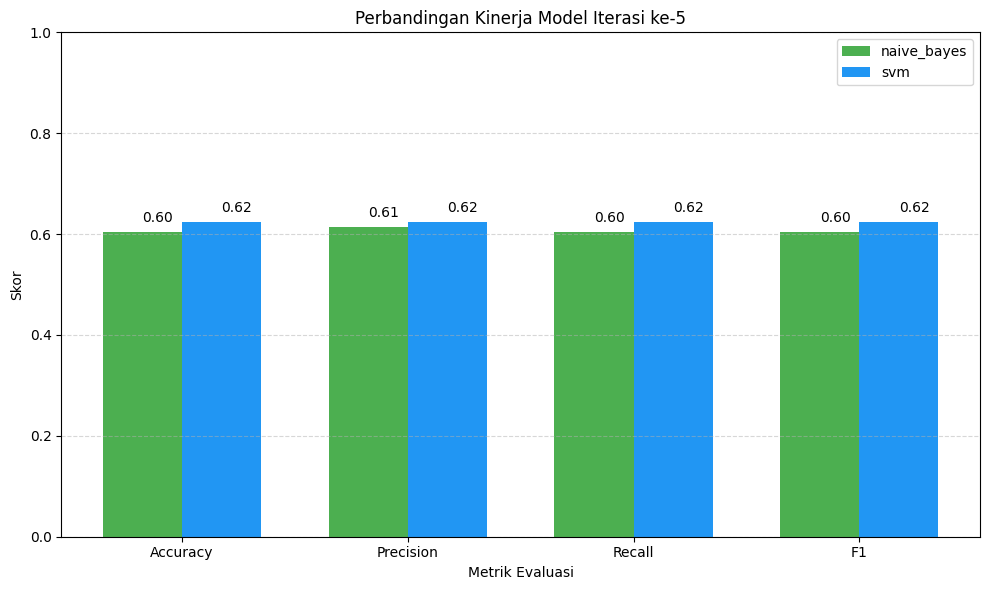

In [16]:
# Persiapan data untuk plotting
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Filter models to only include those with metrics dictionary
models = [key for key in results.keys() if isinstance(results[key], dict) and 'metrics' in results[key]]

score_5 = {model: [results[model]['metrics'][m]['scores'][4] for m in metrics] for model in models}

# Plot
x = np.arange(len(metrics))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - bar_width/2, score_5[models[0]], bar_width, capsize=5,
               label=models[0], color='#4CAF50')
bars2 = ax.bar(x + bar_width/2, score_5[models[1]], bar_width, capsize=5,
               label=models[1], color='#2196F3')

# Label dan dekorasi
ax.set_xlabel('Metrik Evaluasi')
ax.set_ylabel('Skor')
ax.set_title('Perbandingan Kinerja Model Iterasi ke-5')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_ylim(0, 1)
ax.legend()

# Tambahkan nilai di atas bar
for i in range(len(metrics)):
    ax.text(x[i] - bar_width/2, score_5[models[0]][i] + 0.02, f'{score_5[models[0]][i]:.2f}', ha='left')
    ax.text(x[i] + bar_width/2, score_5[models[1]][i] + 0.02, f'{score_5[models[1]][i]:.2f}', ha='left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

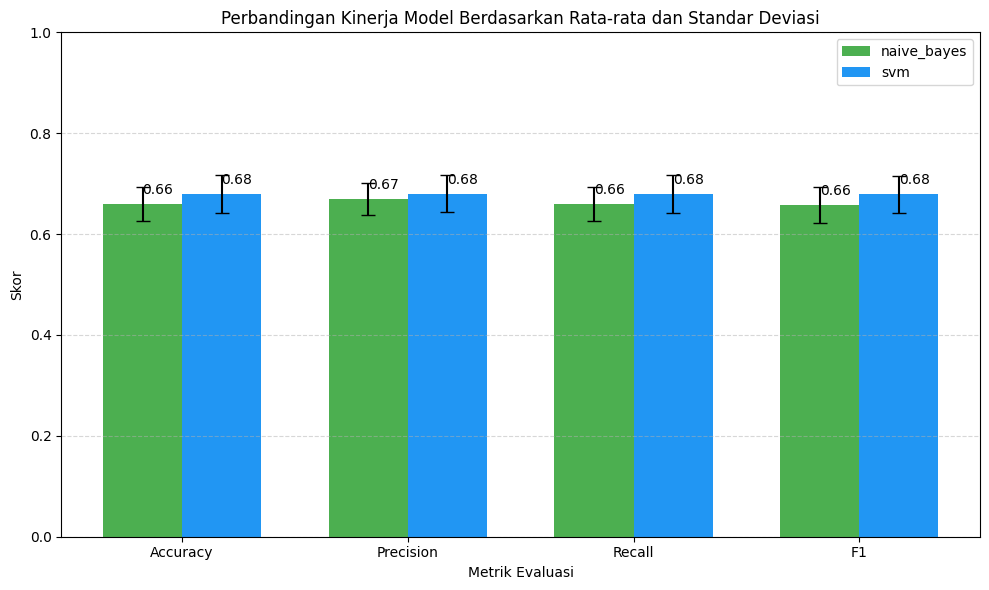

In [17]:
# Persiapan data untuk plotting
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Filter models to only include those with metrics dictionary
models = [key for key in results.keys() if isinstance(results[key], dict) and 'metrics' in results[key]]

means = {model: [results[model]['metrics'][m]['mean'] for m in metrics] for model in models}
stds = {model: [results[model]['metrics'][m]['std'] for m in metrics] for model in models}

# Plot
x = np.arange(len(metrics))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - bar_width/2, means[models[0]], bar_width, yerr=stds[models[0]], capsize=5,
               label=models[0], color='#4CAF50')
bars2 = ax.bar(x + bar_width/2, means[models[1]], bar_width, yerr=stds[models[1]], capsize=5,
               label=models[1], color='#2196F3')

# Label dan dekorasi
ax.set_xlabel('Metrik Evaluasi')
ax.set_ylabel('Skor')
ax.set_title('Perbandingan Kinerja Model Berdasarkan Rata-rata dan Standar Deviasi')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_ylim(0, 1)
ax.legend()

# Tambahkan nilai di atas bar
for i in range(len(metrics)):
    ax.text(x[i] - bar_width/2, means[models[0]][i] + 0.02, f'{means[models[0]][i]:.2f}', ha='left')
    ax.text(x[i] + bar_width/2, means[models[1]][i] + 0.02, f'{means[models[1]][i]:.2f}', ha='left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
